# Task 3: Multimodal ML – Housing Price Prediction

## Objective
Predict housing prices using both structured data (tabular) and house images.

## Dataset
**Source**: from https://www.kaggle.com/datasets/ted8080/house-prices-and-images-socal/data  

## Instructions
1. Use CNNs to extract features from images.
2. Combine extracted image features with tabular data.
3. Train a model using both modalities.
4. Evaluate performance using MAE and RMSE.
5. Provide a Gradio Interface for demo.

In [ ]:
# # Install necessary libraries if not present
# !pip install torch torchvision pandas scikit-learn matplotlib seaborn gradio pillow

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import gradio as gr

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Dataset Loading & Preprocessing


In [11]:
# Define path to the zip file in Google Drive
ZIP_PATH = "/content/drive/MyDrive/archive.zip"

# Unzip the dataset into /content/
!unzip -q {ZIP_PATH} -d /content/



In [12]:
# Define paths after extraction based on where files were actually extracted
# The available files indicate socal2.csv is directly in /content/
CSV_PATH = "/content/socal2.csv"
IMG_DIR = "/content/socal2/socal_pics"

# Load CSV
df = pd.read_csv(CSV_PATH)
print(f"Total samples: {len(df)}")
df.head()

Total samples: 15474


,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [13]:
# Data Cleaning & Feature Engineering

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# We will use the 'image_id' to link to images.
# The image_id is an integer, the files are like '0.jpg'.
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(IMG_DIR, f"{x}.jpg"))

# Filter out rows where image doesn't exist (just in case)
df = df[df['image_path'].apply(os.path.exists)]
print(f"Samples after image check: {len(df)}")

# Define features
# We'll use 'bed', 'bath', 'sqft' as numerical features
# And 'citi' might be categorical, let's keep it simple for now and use numerical + maybe dropped columns

numerical_features = ['bed', 'bath', 'sqft']
# Assuming 'citi' is categorical, we can one-hot encode it, but it might have many unique values.
categorical_features = [] # 'citi' has too many values? Let's check.
print(f"Unique cities: {df['citi'].nunique()}")

# If unique cities are manageable, we add it. Otherwise, we might skip it or use embeddings.
# For this task, let's stick to numerical features to keep the dense network simple,
# or if < 50, use one-hot.
if df['citi'].nunique() < 50:
    categorical_features = ['citi']
    print("Including 'citi' as categorical feature.")
else:
    print("Skipping 'citi' due to high cardinality.")

# Target
target_col = 'price'

# Image Preprocessing
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tabular Preprocessing
# We need to fit scalers on training data only to avoid leakage.
X = df[numerical_features + categorical_features]
y = df[target_col].values.astype(np.float32)
image_paths = df['image_path'].values

# Split Data
X_train_raw, X_test_raw, y_train, y_test, img_train, img_test = train_test_split(
    X, y, image_paths, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val, img_train, img_val = train_test_split(
    X_train_raw, y_train, img_train, test_size=0.1, random_state=42
)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test_raw)}")

# Preprocesor for Tabular Data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test_raw)

print(f"Processed tabular shape: {X_train_processed.shape}")

Missing values:
 image_id    0
street      0
citi        0
n_citi      0
bed         0
bath        0
sqft        0
price       0
dtype: int64
Samples after image check: 15474
Unique cities: 415
Skipping 'citi' due to high cardinality.
Train size: 11141, Val size: 1238, Test size: 3095
Processed tabular shape: (11141, 3)


In [14]:
class Housingdataset(Dataset):
    def __init__(self, tabular_data, image_paths, targets=None, transform=None):
        self.tabular_data = tabular_data
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load Image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Tabular features
        tabular = torch.tensor(self.tabular_data[idx], dtype=torch.float32)

        if self.targets is not None:
            target = torch.tensor(self.targets[idx], dtype=torch.float32)
            return image, tabular, target
        else:
            return image, tabular

# Create Datasets
train_dataset = Housingdataset(X_train_processed, img_train, y_train, image_transforms)
val_dataset = Housingdataset(X_val_processed, img_val, y_val, image_transforms)
test_dataset = Housingdataset(X_test_processed, img_test, y_test, image_transforms)

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


## 2. Model Development


In [15]:
class MultimodalHousingModel(nn.Module):
    def __init__(self, num_tabular_features):
        super(MultimodalHousingModel, self).__init__()

        # Image Branch (ResNet)
        self.cnn = models.resnet18(pretrained=True)
        # Remove the classification head
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()

        # Tabular Branch (MLP)
        self.tabular_mlp = nn.Sequential(
            nn.Linear(num_tabular_features, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Fusion
        self.fusion = nn.Sequential(
            nn.Linear(num_ftrs + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Regression output
        )

    def forward(self, image, tabular):
        # Image features
        x_img = self.cnn(image)

        # Tabular features
        x_tab = self.tabular_mlp(tabular)

        # Concatenate
        combined = torch.cat((x_img, x_tab), dim=1)

        # Final prediction
        out = self.fusion(combined)
        return out.squeeze()

model = MultimodalHousingModel(num_tabular_features=X_train_processed.shape[1])
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


## 3. Training Loop


Epoch 1/11, Train Loss: 424668912964.73, Val Loss: 103584127224.14
Epoch 2/11, Train Loss: 106161417736.69, Val Loss: 96059776044.67
Epoch 3/11, Train Loss: 97042794523.02, Val Loss: 89958211438.42
Epoch 4/11, Train Loss: 93134488182.25, Val Loss: 86019008105.05
Epoch 5/11, Train Loss: 90582349332.27, Val Loss: 85309399106.17
Epoch 6/11, Train Loss: 90880000143.38, Val Loss: 84558841806.37
Epoch 7/11, Train Loss: 89324240415.85, Val Loss: 84976892774.15
Epoch 8/11, Train Loss: 88162292949.88, Val Loss: 83124879399.70
Epoch 9/11, Train Loss: 87236707498.77, Val Loss: 82087939943.81
Epoch 10/11, Train Loss: 85769954728.91, Val Loss: 83408351701.82
Epoch 11/11, Train Loss: 84092870337.43, Val Loss: 84739839784.94


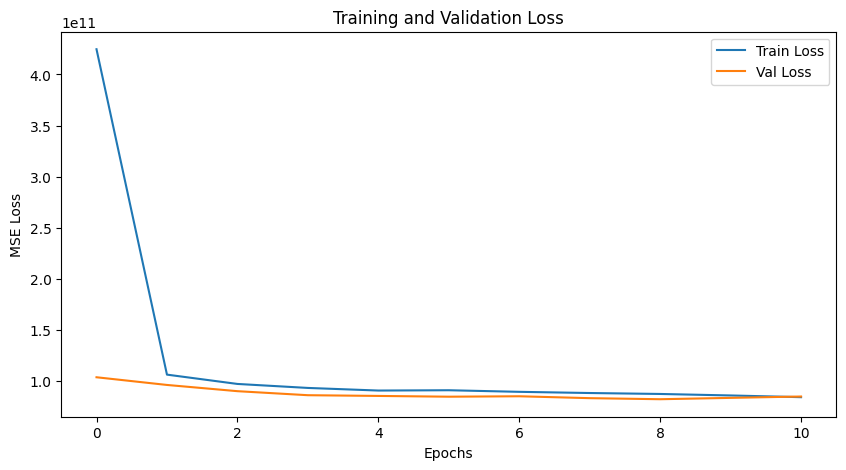

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 11
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, tabulars, targets in train_loader:
        images, tabulars, targets = images.to(device), tabulars.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images, tabulars)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, tabulars, targets in val_loader:
            images, tabulars, targets = images.to(device), tabulars.to(device), targets.to(device)
            outputs = model(images, tabulars)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * images.size(0)

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_loss:.2f}, Val Loss: {epoch_val_loss:.2f}")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'housing_model.pth')
print('Model saved to housing_model.pth')

## 4. Evaluation


Test MAE: $216,114.20
Test RMSE: $300,662.18
Mean Price: $707,084.56


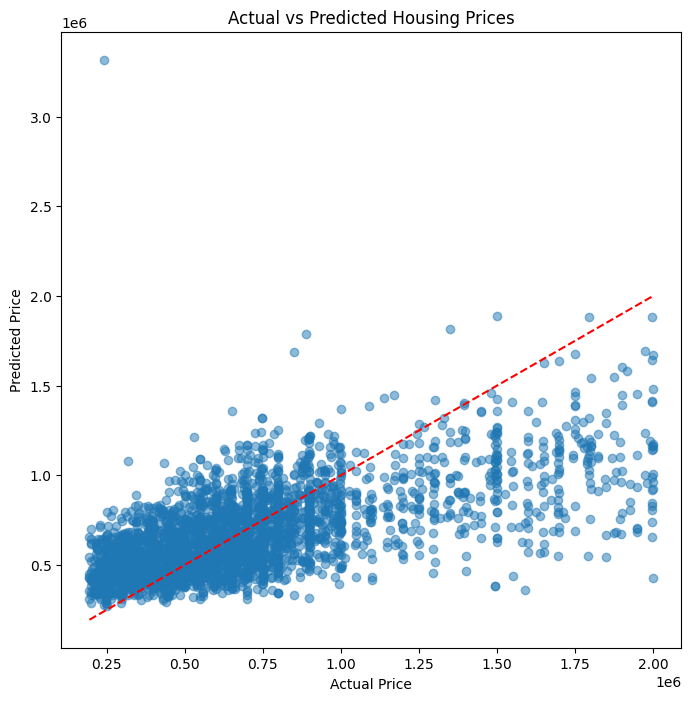

In [17]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, tabulars, targets in test_loader:
        images, tabulars, targets = images.to(device), tabulars.to(device), targets.to(device)
        outputs = model(images, tabulars)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Test MAE: ${mae:,.2f}")
print(f"Test RMSE: ${rmse:,.2f}")
print(f"Mean Price: ${np.mean(y_true):,.2f}")

# Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Housing Prices')
plt.show()

## 5. Gradio Interface


In [18]:
def predict_house_price(bed, bath, sqft, image):
    # Preprocess Image
    if image is None:
        return "Please upload an image"

    image = Image.fromarray(image).convert('RGB')
    img_tensor = image_transforms(image).unsqueeze(0).to(device)

    # Preprocess Tabular
    # Create a DataFrame for the single input
    input_df = pd.DataFrame([[bed, bath, sqft]], columns=['bed', 'bath', 'sqft'])

    # Note: We need to handle the full columns expected by the preprocessor.
    # The training preprocessor expects 'citi' as well if we included it.
    # For simplicity in this demo, if 'citi' was used, we need to supply a dummy or ask for it.
    # Let's assume we used 'citi'. We'll just pass a common city or handle it.
    # Since we dynamically check 'citi' above, we need to be careful.
    # A robust way is to save the columns used.
    # Here, let's just create a dummy row matching the training schema.

    # Re-create the input structure based on training data columns
    # We'll retrieve the column names from the X_train dataframe used earlier if possible,
    # but here we'll just try to construct it.

    # If 'citi' is in categorical_features, we need to provide it.
    # For this demo, let's assume valid numerical inputs + a dummy city if needed.

    data_dict = {'bed': [bed], 'bath': [bath], 'sqft': [sqft]}
    if 'citi' in categorical_features:
        data_dict['citi'] = [df['citi'].mode()[0]] # Default to most common city

    input_df = pd.DataFrame(data_dict)

    # Transform
    tab_processed = preprocessor.transform(input_df)
    tab_tensor = torch.tensor(tab_processed, dtype=torch.float32).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        prediction = model(img_tensor, tab_tensor)

    return f"${prediction.item():,.2f}"

# Create Gradio UI
iface = gr.Interface(
    fn=predict_house_price,
    inputs=[
        gr.Number(label="Bedrooms", value=3),
        gr.Number(label="Bathrooms", value=2),
        gr.Number(label="Square Feet", value=1500),
        gr.Image(label="House Image")
    ],
    outputs="text",
    title="Multimodal Housing Price Prediction",
    description="Estimate house price based on features and image."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://32258964f277eff19d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
